<a href="https://colab.research.google.com/github/geun-hyoung/python_local_outlier_factor_text_info/blob/main/lof_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting

In [1]:
# Restart!
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!pip install gensim
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pyLDAvis
!pip install tqdm
!pip install transformers
!pip install keybert
!pip install umap-learn
!pip install ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/664.8 MB 32.8 MB/s eta 0:00:13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HAS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd

import spacy
from bs4 import BeautifulSoup

Mounted at /content/drive


## 1. Data load & Cleaning

In [5]:
import json

attraction_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/korea_attraction_info.csv')

# 데이터프레임 확인
print(attraction_df.shape)
attraction_df.head()

(1422, 9)


,searched_name,search_result,attraction_info,source,similarity,english_info,attraction_korean_name,attraction_english_name,name
0,에버랜드,에버랜드,"1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...",second,100.0,This theme park offers enjoyable relaxation an...,에버랜드,Everland,Everland
1,리움 미술관,리움 미술관,삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...,second,100.0,The Samsung Cultural Foundation has contribute...,리움 미술관,Leeum Art Museum,Leeum Art Museum
2,협재해수욕장,협재해수욕장,협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...,second,100.0,"Hyeopjae Beach is adjacent to Hallim Park, 32k...",협재해수욕장,Hyeopjae Beach,Hyeopjae Beach
3,레고랜드 코리아 리조트,레고랜드 코리아 리조트,레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...,second,100.0,"LEGOLAND® Korea Resort, located in Jungdo, Chu...",레고랜드 코리아 리조트,Legoland Korea Resort,Legoland Korea Resort
4,익선동 한옥거리,익선동 한옥거리,"익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...",second,100.0,Ikseon-dong is a place where alleys and hanoks...,익선동 한옥거리,Ikseon-dong Hanok Street,Ikseon-dong Hanok Street


In [6]:
# ✅ 제거할 열 목록
columns_to_drop = ['searched_name', 'source', 'similarity', 'attraction_korean_name', 'attraction_english_name']

# ✅ 열 제거 (존재하지 않는 열은 무시)
attraction_df = attraction_df.drop(columns=columns_to_drop, errors='ignore')

# ✅ 결과 확인
print("✅ 지정된 열 제거 완료.")
display(attraction_df.head())

✅ 지정된 열 제거 완료.


,search_result,attraction_info,english_info,name
0,에버랜드,"1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...",This theme park offers enjoyable relaxation an...,Everland
1,리움 미술관,삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...,The Samsung Cultural Foundation has contribute...,Leeum Art Museum
2,협재해수욕장,협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...,"Hyeopjae Beach is adjacent to Hallim Park, 32k...",Hyeopjae Beach
3,레고랜드 코리아 리조트,레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...,"LEGOLAND® Korea Resort, located in Jungdo, Chu...",Legoland Korea Resort
4,익선동 한옥거리,"익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...",Ikseon-dong is a place where alleys and hanoks...,Ikseon-dong Hanok Street


In [9]:
# ✅ 1. 결측치 제거 (name, english_info 기준)
initial_count = attraction_df.shape[0]
after_dropna = attraction_df.dropna(subset=['name', 'english_info'])
dropna_count = initial_count - after_dropna.shape[0]
print(f"🚫 결측치 제거 (name, english_info 기준): {dropna_count}개 제거 (남은 데이터: {after_dropna.shape[0]}개)")

# ✅ 2. 공백 제거 (info 열 생성)
after_strip = after_dropna.copy()
after_strip['info'] = after_strip['name'].str.strip()

# ✅ 3. 빈 문자열 제거 (info 기준)
after_non_empty = after_strip[after_strip['info'] != '']
empty_string_count = after_strip.shape[0] - after_non_empty.shape[0]
print(f"🚫 빈 문자열 제거: {empty_string_count}개 제거 (남은 데이터: {after_non_empty.shape[0]}개)")

# ✅ 4. 중복 제거 (name, english_info 기준)
after_dedup = after_non_empty.drop_duplicates(subset=['name', 'english_info'])
dedup_count = after_non_empty.shape[0] - after_dedup.shape[0]
print(f"🚫 중복 제거 (name, english_info 기준): {dedup_count}개 제거 (남은 데이터: {after_dedup.shape[0]}개)")

# ✅ 5. 'searched_name' 열 제거
attraction_df_cleaned = after_dedup.drop(columns=['searched_name'], errors='ignore')
print("🗑️ 'searched_name' 열 제거 완료.")

# ✅ 최종 결과 출력
print(f"✅ 최종 클린된 DataFrame 크기: {attraction_df_cleaned.shape[0]}개")

🚫 결측치 제거 (name, english_info 기준): 0개 제거 (남은 데이터: 1422개)
🚫 빈 문자열 제거: 0개 제거 (남은 데이터: 1422개)
🚫 중복 제거 (name, english_info 기준): 28개 제거 (남은 데이터: 1394개)
🗑️ 'searched_name' 열 제거 완료.
✅ 최종 클린된 DataFrame 크기: 1394개


In [11]:
import json

review_path = "/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/reviews_info.json"

# JSON 파일 읽기
with open(review_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터 확인
if isinstance(data, list):  # 리스트 형태의 JSON
    review_df = pd.json_normalize(data)
elif isinstance(data, dict):  # 딕셔너리 형태의 JSON
    if "key_with_nested_data" in data:  # 중첩된 키가 있는 경우
        review_df = pd.json_normalize(data, record_path='key_with_nested_data', meta=['parent_key1', 'parent_key2'])
    else:
        review_df = pd.json_normalize(data)
else:
    raise ValueError("Unsupported JSON structure.")

# 데이터프레임 확인
print(review_df.shape)
review_df.head()

(273622, 9)


,attraction_name,name,contributions,location,score,tag,date,content,profileUrl
0,Gyeongbokgung Palace,Tom F,37,,5,nice palace,Nov 2024 • Couples,"There are several palaces in downtown Seoul, a...",https://www.tripadvisor.com/Profile/W6358IDtomf
1,Gyeongbokgung Palace,eriquef2017,29,"Puerto Escondido, Mexico",5,History surrounding you!,Oct 2024 • Couples,Exceptionally preserved and restored history o...,https://www.tripadvisor.com/Profile/eriquef2017
2,Gyeongbokgung Palace,colin h,73,"Ely, United Kingdom",5,Must see palace if in Seoul.,Nov 2024 • Solo,The largest of the palaces in Seoul and it doe...,https://www.tripadvisor.com/Profile/colinhaley812
3,Gyeongbokgung Palace,Natari,33,"Almaty, Kazakhstan",5,Experience the spirit of Korea,Sep 2024 • Solo,"Undoubtedly, it’s a must see place, especially...",https://www.tripadvisor.com/Profile/W7498XRnat...
4,Gyeongbokgung Palace,Luc,442,"Brisbane, Australia",5,Must visit in Seoul,Oct 2024 • Friends,This is a huge palace and stunning to explore....,https://www.tripadvisor.com/Profile/luci321


In [13]:
import pandas as pd
import re
import spacy

# ✅ 데이터프레임 복사
preprocessed_df = attraction_df_cleaned.copy()

# ✅ spaCy 모델 로드
nlp = spacy.load('en_core_web_sm')

# ✅ 정규식 패턴 정의
english_word_regex = re.compile(r'^[a-z]+$')  # 영어 소문자만 남기기
non_english_or_digit_regex = re.compile(r'[^\x00-\x7F]+|\d')  # 한국어, 숫자, 기타 비영어 문자 제거

# ✅ 전처리 함수 정의
def preprocess_text(text):
    if not isinstance(text, str):  # 문자열이 아닌 경우 빈 문자열 반환
        return None

    # 1️⃣ 정규식을 사용하여 숫자, 한국어, 특수 문자 제거
    text = text.lower()  # 소문자화
    text = re.sub(non_english_or_digit_regex, '', text)  # 숫자 및 비영어 문자 제거

    # 2️⃣ spaCy를 사용한 텍스트 분석 (토큰화 포함)
    doc = nlp(text)

    # 3️⃣ 토큰화, 불필요한 토큰 제거
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha  # 알파벳으로만 이루어진 토큰
        and english_word_regex.match(token.lemma_)  # 영어 단어만 유지
    ]

    # 4️⃣ 5개 미만 단어 제거
    if len(tokens) < 5:
        return None

    # 최종 토큰 리스트를 문자열로 변환
    return ' '.join(tokens)

# ✅ 'english_info' 컬럼에 전처리 적용
preprocessed_df['corpus'] = preprocessed_df['english_info'].apply(preprocess_text)

# ✅ None 값 제거 및 인덱스 초기화
preprocessed_df = preprocessed_df.dropna(subset=['corpus']).reset_index(drop=True)
preprocessed_df.to_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/preprocessed_dataset.csv', encoding='utf-8-sig')

# ✅ 결과 확인
print(preprocessed_df.shape)
preprocessed_df.head()

(1391, 6)


,search_result,attraction_info,english_info,name,info,corpus
0,에버랜드,"1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...",This theme park offers enjoyable relaxation an...,Everland,Everland,this theme park offer enjoyable relaxation and...
1,리움 미술관,삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...,The Samsung Cultural Foundation has contribute...,Leeum Art Museum,Leeum Art Museum,the samsung cultural foundation have contribut...
2,협재해수욕장,협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...,"Hyeopjae Beach is adjacent to Hallim Park, 32k...",Hyeopjae Beach,Hyeopjae Beach,hyeopjae beach be adjacent to hallim park km w...
3,레고랜드 코리아 리조트,레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...,"LEGOLAND® Korea Resort, located in Jungdo, Chu...",Legoland Korea Resort,Legoland Korea Resort,legoland korea resort locate in jungdo chunche...
4,익선동 한옥거리,"익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...",Ikseon-dong is a place where alleys and hanoks...,Ikseon-dong Hanok Street,Ikseon-dong Hanok Street,ikseon dong be a place where alley and hanok c...


In [17]:
# 1️⃣ review_df에서 attraction_name 기준 리뷰 개수 계산
review_counts = review_df.groupby('attraction_name').size().reset_index(name='review_cnt')

# 2️⃣ preprocessed_df와 review_counts 병합 (name ↔ attraction_name 기준)
merged_df = preprocessed_df.merge(
    review_counts, left_on='name', right_on='attraction_name', how='left'
)

# 3️⃣ 병합되지 않은 name 추출
unmerged_names = merged_df[merged_df['review_cnt'].isna()]['name'].unique().tolist()

# 4️⃣ 리뷰 개수가 없는 경우 0으로 채우기
merged_df['review_cnt'] = merged_df['review_cnt'].fillna(0).astype(int)

# ✅ 결과 확인 (표준 출력)
print("✅ 병합 및 리뷰 개수 추가 완료!")
print(f"🚫 병합되지 않은 name 개수: {len(unmerged_names)}개")
if unmerged_names:
    print(f"🔍 병합되지 않은 name 목록: {unmerged_names}")
else:
    print("✅ 모든 name이 성공적으로 병합되었습니다.")

# ✅ 병합된 데이터프레임 미리보기
print("\n📊 병합된 데이터프레임 미리보기:")
print(merged_df.head())

✅ 병합 및 리뷰 개수 추가 완료!
🚫 병합되지 않은 name 개수: 5개
🔍 병합되지 않은 name 목록: ['Apsan Mountain Haeneomi Observatory', 'Hyeonnyeonwon Park', 'Hanyangdoseong Historic Site Museum', 'Hwalok Cave', 'Samaksan']

📊 병합된 데이터프레임 미리보기:
  search_result                                    attraction_info  \
0          에버랜드  1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...   
1        리움 미술관  삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...   
2        협재해수욕장  협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...   
3  레고랜드 코리아 리조트  레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...   
4      익선동 한옥거리  익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...   

                                        english_info  \
0  This theme park offers enjoyable relaxation an...   
1  The Samsung Cultural Foundation has contribute...   
2  Hyeopjae Beach is adjacent to Hallim Park, 32k...   
3  LEGOLAND® Korea Resort, located in Jungdo, Chu...   
4  Ikseon-dong is a place where alleys and hanoks...   

                       name      

## 2. Text Embedding (SentenceTransformer)

In [37]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap

model = SentenceTransformer('all-MiniLM-L6-v2')  # 빠르고 효율적인 모델
embeddings = model.encode(merged_df['corpus'], convert_to_tensor=False)
merged_df['embedding'] = embeddings.tolist()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


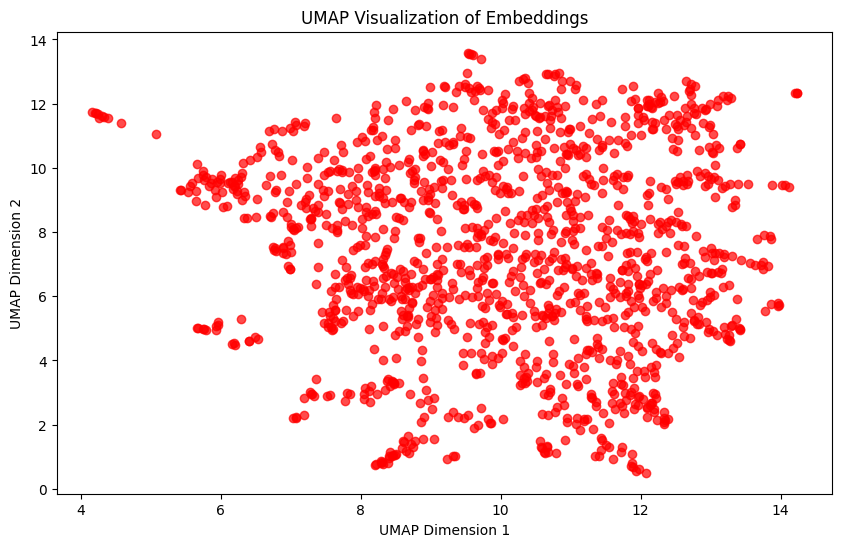

In [20]:
# 정규화
scaler = StandardScaler()
embedding_vectors = scaler.fit_transform(merged_df['embedding'].tolist())

import matplotlib.pyplot as plt
import umap

umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embedding_vectors)

# UMAP 시각화
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c='red')

plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## 3. Local Outlier Factor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


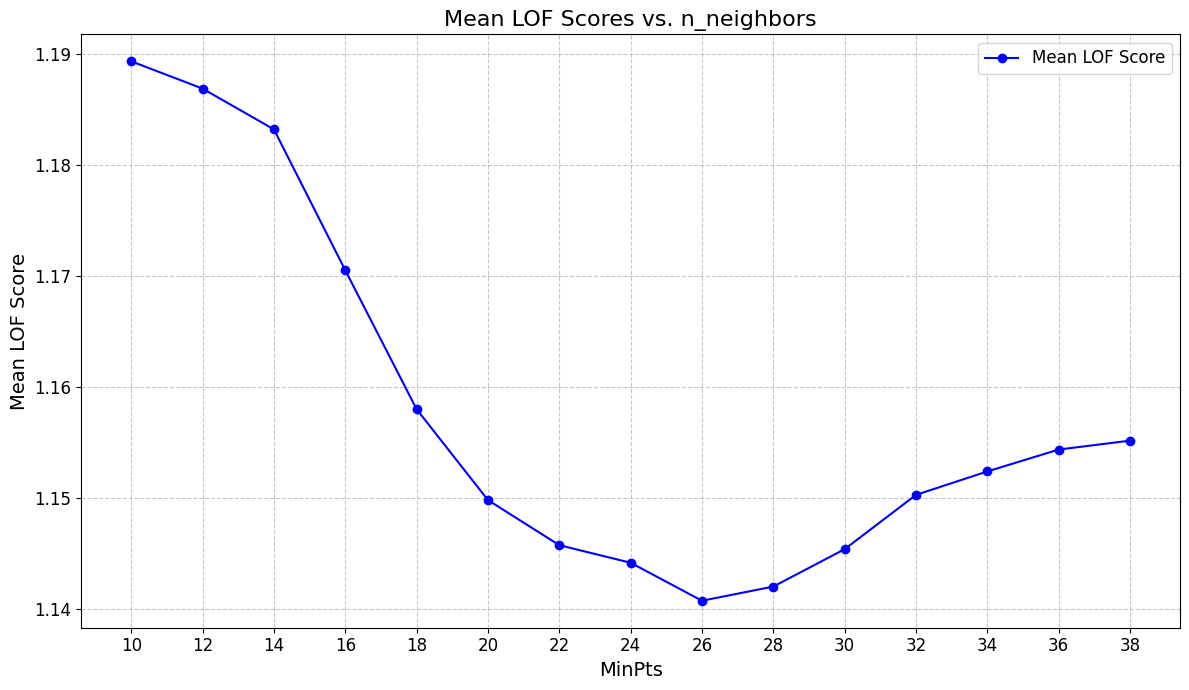

In [25]:
from sklearn.neighbors import LocalOutlierFactor

umap_reducer = umap.UMAP(n_components=10, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embedding_vectors)

# LOF 실험 범위 설정 (5부터 30까지 2씩 증가)
n_neighbors_range = range(10, 40, 2)

# 각 n_neighbors의 평균 LOF 점수 저장
lof_mean_scores = []

for n in n_neighbors_range:
    lof = LocalOutlierFactor(n_neighbors=n, metric='cosine', contamination=0.1)
    lof.fit_predict(reduced_embeddings)  # LOF 점수 계산
    lof_scores = -lof.negative_outlier_factor_  # LOF 점수 추출
    mean_lof_score = lof_scores.mean()
    lof_mean_scores.append((n, mean_lof_score))

# 결과 정리
lof_mean_df = pd.DataFrame(lof_mean_scores, columns=['n_neighbors', 'mean_lof_score'])

# 시각화
plt.figure(figsize=(12, 7))
plt.plot(lof_mean_df['n_neighbors'], lof_mean_df['mean_lof_score'], marker='o', linestyle='-', color='b', label='Mean LOF Score')
plt.title("Mean LOF Scores vs. n_neighbors", fontsize=16)
plt.xlabel("MinPts", fontsize=14)
plt.ylabel("Mean LOF Score", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(lof_mean_df['n_neighbors'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [34]:
# LOF 적용
lof = LocalOutlierFactor(n_neighbors=14, metric='cosine', contamination=0.1)
lof.fit(reduced_embeddings)
merged_df['LOF_Score'] = -lof.negative_outlier_factor_  # LOF 점수
merged_df['is_outlier'] = lof.fit_predict(reduced_embeddings)  # -1: 이상치, 1: 정상치

# LOF 점수에 따라 정렬
sorted_df = merged_df.sort_values(by='LOF_Score', ascending=False)
sorted_df.to_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/lof_analysis_result.csv', encoding='utf-8')

In [30]:
sorted_df.head(10)

,search_result,attraction_info,english_info,name,info,corpus,attraction_name,review_cnt,embedding,LOF_Score,is_outlier
996,충주 활옥동굴,"1922년 일제강점기에 개발된 국내 유일 활석 광산으로 기록상 57km, 비공식 8...",It is the only talc mine in Korea developed du...,Hwalok Cave,Hwalok Cave,it be the only talc mine in korea develop duri...,NaN,0,"[-0.08450809866189957, 0.05948633700609207, 0....",4.013665,-1
898,통일전 은행나무길,통일전 은행나무길은 경주시의 대표적인 가을 명소로 손꼽히는 곳이라고 할 수 있다. ...,The Tongiljeon Ginkgo Tree Road is considered ...,Gingko Tree Road,Gingko Tree Road,the tongiljeon ginkgo tree road be consider on...,Gingko Tree Road,4,"[0.0104845454916358, 0.09078939259052277, 0.02...",3.485174,-1
1002,대한성공회 강화성당,강화성당은 고요한 (Charies Jone Corfe) 초대주교가 1900년에 축성...,Ganghwa Cathedral was built in 1900 by the fir...,Ganghwa Anglican Cathedral,Ganghwa Anglican Cathedral,ganghwa cathedral be build in by the first bis...,Ganghwa Anglican Cathedral,3,"[0.047638799995183945, 0.046310052275657654, 0...",3.217466,-1
1142,대한성공회 서울주교좌성당,대한성공회 서울주교좌성당은 친교의 신앙으로 선교하는 제자공동체이다. 이 건물은 대한...,"The Anglican Church of Korea, Seoul Cathedral ...",Seoul Anglican Cathedral,Seoul Anglican Cathedral,the anglican church of korea seoul cathedral b...,Seoul Anglican Cathedral,7,"[0.040632497519254684, 0.036646075546741486, 0...",3.199203,-1
1381,나바위 성당(화산천주교회),나바위 성당은 조선 헌종 11년(1845년) 김대건 신부가 중국에서 사제서품을 받고...,Nabawi Cathedral was built in 1845 (the 11th y...,Choryang Catholic Church,Choryang Catholic Church,nabawi cathedral be build in the th year of ki...,Choryang Catholic Church,4,"[-0.005303469020873308, 0.0771574005484581, 0....",3.189261,-1
881,서울 약현성당,"약현(藥峴) 성당(聖堂)은 길이 약 32m, 너비가 12m로 이루어진 396m²(1...",Yakhyeon (藥峴) Cathedral (聖堂) is a small cathed...,Yakhyeon Catholic Church,Yakhyeon Catholic Church,yakhyeon cathedral be a small cathedral buildi...,Yakhyeon Catholic Church,3,"[0.013802526518702507, 0.05233502760529518, -0...",3.146942,-1
486,동명동성당,강원도 속초시 동명동에 있는 춘천교구 소속의 가톨릭 천주교회이다. 속초 터미널 인근...,It is a Catholic church belonging to the Chunc...,Myeong-dong Cathedral,Myeong-dong Cathedral,it be a catholic church belong to the chuncheo...,Myeong-dong Cathedral,447,"[0.07232098281383514, 0.06845522671937943, 0.0...",3.139475,-1
884,서울 정동교회,정동 교회는 개신교가 이 땅에 보급된 후 가장 먼저 세워진 교회이다. 1885년 미...,Jeongdong Church was the first church establis...,Chungdong Church,Chungdong Church,jeongdong church be the first church establish...,Chungdong Church,3,"[0.024506723508238792, 0.08963844925165176, 0....",3.138699,-1
795,역삼동성당,강남지역의 교세 신장에 따라 1984년 8월 1일 대치동 성당과 양재동 성당의 관할...,Due to the growth of the church in the Gangnam...,Yeoksam Catholic Church,Yeoksam Catholic Church,due to the growth of the church in the gangnam...,Yeoksam Catholic Church,1,"[-0.0006506142090074718, 0.07058748602867126, ...",3.134848,-1
545,관방제림\n,관방제는 관방천에 있는 제방으로서 담양읍 남산리 동정자 마을로부터 수북면 황금리를 ...,Gwanbangje is an embankment on Gwanbangcheon S...,Gwanbangjerim Forest,Gwanbangjerim Forest,gwanbangje be an embankment on gwanbangcheon s...,Gwanbangjerim Forest,3,"[0.03745671734213829, 0.08825276046991348, 0.0...",3.121556,-1


In [31]:
sorted_df.tail(10)

,search_result,attraction_info,english_info,name,info,corpus,attraction_name,review_cnt,embedding,LOF_Score,is_outlier
814,서울백제어린이박물관,서울백제어린이박물관은 몽촌토성이 고대국가 백제의 왕성이었다는 사실과 서울의 2천년 ...,The Seoul Baekje Children's Museum is the only...,Seoul Baekje Museum,Seoul Baekje Museum,the seoul baekje child museum be the only chil...,Seoul Baekje Museum,8,"[-0.024184850975871086, 0.1150093823671341, 0....",0.893512,1
804,국립 검마산자연휴양림,신원리에 위치한 검마산 자연휴양림은 산림 속 나무에서 뿜어 내는 피톤치드 (Phyt...,The Geommasan Natural Recreation Forest locate...,Geommasan Recreational Forest,Geommasan Recreational Forest,the geommasan natural recreation forest locate...,Geommasan Recreational Forest,1,"[0.06645181775093079, -0.00815429724752903, 0....",0.892629,1
773,월드온천24,월드온천24는 춘천시 신북읍에 위치한 온천이다. 총 3층 건물에 내부는 넓고 다양한...,World Hot Spring 24 is a hot spring located in...,World Oncheon,World Oncheon,world hot spring be a hot spring locate in sin...,World Oncheon,1,"[0.023811012506484985, -0.01318561565130949, 0...",0.890184,1
1145,경주 감은사지,감은사는 동해안에 있는 통일신라시대의 사찰로 신라 문무왕이 삼국을 통일한 후 부처의...,Gamsansa Temple is a temple from the Unified S...,Gameunsa Temple Site,Gameunsa Temple Site,gamsansa temple be a temple from the unified s...,Gameunsa Temple Site,2,"[-0.06240331381559372, 0.06725616008043289, -0...",0.881166,1
647,매미성\n,매미성은 2003년 태풍 매미로 경작지를 잃은 시민 백순삼 씨가 자연재해로부터 작물...,"Maemi Castle is a wall that Mr. Baek Soon-sam,...",Maemiseong,Maemiseong,maemi castle be a wall that mr baek soon sam a...,Maemiseong,11,"[0.05814952775835991, 0.08331390470266342, -0....",0.881123,1
979,허심청,허심청은 편안하고 즐거운 온천욕과 휴식 및 체력단련을 통한 건강증진을 추구하는 새로...,Heosimcheong is a new type of urban hot spring...,Hurshimchung Spa,Hurshimchung Spa,heosimcheong be a new type of urban hot spring...,Hurshimchung Spa,36,"[0.028020471334457397, 0.06146526336669922, 0....",0.881022,1
115,땅끝해양자연사박물관,"세계적인 패류와 산호류, 어류, 포유류, 갑각류, 화석류, 파충류, 육지 곤충에 이...",It is a place with the best variety of shellfi...,Ttangkkeut Marine Natural History Museum,Ttangkkeut Marine Natural History Museum,it be a place with the good variety of shellfi...,Ttangkkeut Marine Natural History Museum,2,"[-0.02372344769537449, 0.09720048308372498, -0...",0.877890,1
113,부산해양자연사박물관,"부산 해양자연사박물관은 해양의 중요성을 인식하고, 사라져가는 소중한 해양자연사 자료...",The Busan Marine Natural History Museum recogn...,Busan Marine Natural History Museum,Busan Marine Natural History Museum,the busan marine natural history museum recogn...,Busan Marine Natural History Museum,4,"[-0.11148583889007568, 0.06112360581755638, 0....",0.875956,1
1202,대구 스파밸리,스파밸리는 달성군 냉천리에 위치한 온천시설 및 사우나 시설로 2003년에 오픈했다....,Spa Valley is a hot spring and sauna facility ...,Water Park Spavalley,Water Park Spavalley,spa valley be a hot spring and sauna facility ...,Water Park Spavalley,3,"[-0.01929272711277008, -0.03834832087159157, 0...",0.868903,1
1019,하나개해수욕장,하나개해수욕장은 무의도 서쪽에 자리한 갯벌을 품은 해수욕장이다. 하나개는 가장 큰 ...,Hanagae Beach is a beach that embraces the tid...,Hanagae Beach,Hanagae Beach,hanagae beach be a beach that embrace the tida...,Hanagae Beach,2,"[-0.013116051442921162, -0.02581857144832611, ...",0.868615,1


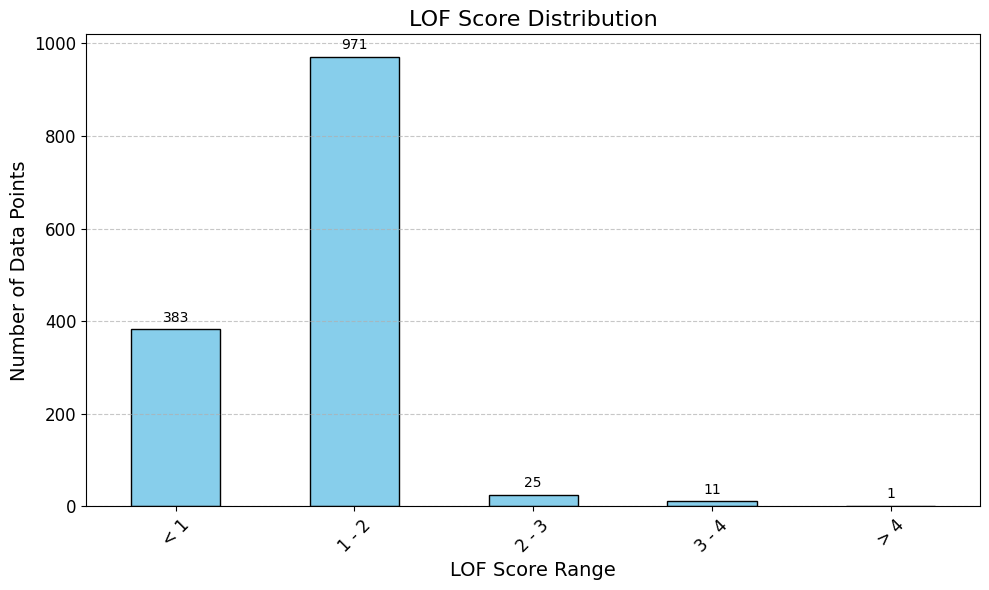

In [36]:
# ✅ 1. LOF_Score 기준 구간 설정
bins = [float('-inf'), 1, 2, 3, 4, float('inf')]
labels = ['< 1', '1 - 2', '2 - 3', '3 - 4', '> 4']

# ✅ 2. LOF_Score 값을 구간에 할당
sorted_df['LOF_Score_Category'] = pd.cut(sorted_df['LOF_Score'], bins=bins, labels=labels)

# ✅ 3. 각 구간별 데이터 개수 계산
category_counts = sorted_df['LOF_Score_Category'].value_counts().sort_index()

# ✅ 4. 시각화 및 바 위에 개수 표시
plt.figure(figsize=(10, 6))
ax = category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('LOF Score Distribution', fontsize=16)
plt.xlabel('LOF Score Range', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ 각 바 위에 개수 표시 및 바 아래에 숫자 표시
for i, (category, value) in enumerate(category_counts.items()):
    # 바 위에 개수 표시
    ax.text(i, value + max(category_counts) * 0.01, f'{value}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## Recomendation attraction

In [47]:
print(sorted_df.shape)
sorted_df.head()

(1391, 12)


,search_result,attraction_info,english_info,name,info,corpus,attraction_name,review_cnt,embedding,LOF_Score,is_outlier,LOF_Score_Category
996,충주 활옥동굴,"1922년 일제강점기에 개발된 국내 유일 활석 광산으로 기록상 57km, 비공식 8...",It is the only talc mine in Korea developed du...,Hwalok Cave,Hwalok Cave,it be the only talc mine in korea develop duri...,NaN,0,"[-0.08450809866189957, 0.05948633700609207, 0....",4.013665,-1,> 4
898,통일전 은행나무길,통일전 은행나무길은 경주시의 대표적인 가을 명소로 손꼽히는 곳이라고 할 수 있다. ...,The Tongiljeon Ginkgo Tree Road is considered ...,Gingko Tree Road,Gingko Tree Road,the tongiljeon ginkgo tree road be consider on...,Gingko Tree Road,4,"[0.0104845454916358, 0.09078939259052277, 0.02...",3.485174,-1,3 - 4
1002,대한성공회 강화성당,강화성당은 고요한 (Charies Jone Corfe) 초대주교가 1900년에 축성...,Ganghwa Cathedral was built in 1900 by the fir...,Ganghwa Anglican Cathedral,Ganghwa Anglican Cathedral,ganghwa cathedral be build in by the first bis...,Ganghwa Anglican Cathedral,3,"[0.047638799995183945, 0.046310052275657654, 0...",3.217466,-1,3 - 4
1142,대한성공회 서울주교좌성당,대한성공회 서울주교좌성당은 친교의 신앙으로 선교하는 제자공동체이다. 이 건물은 대한...,"The Anglican Church of Korea, Seoul Cathedral ...",Seoul Anglican Cathedral,Seoul Anglican Cathedral,the anglican church of korea seoul cathedral b...,Seoul Anglican Cathedral,7,"[0.040632497519254684, 0.036646075546741486, 0...",3.199203,-1,3 - 4
1381,나바위 성당(화산천주교회),나바위 성당은 조선 헌종 11년(1845년) 김대건 신부가 중국에서 사제서품을 받고...,Nabawi Cathedral was built in 1845 (the 11th y...,Choryang Catholic Church,Choryang Catholic Church,nabawi cathedral be build in the th year of ki...,Choryang Catholic Church,4,"[-0.005303469020873308, 0.0771574005484581, 0....",3.189261,-1,3 - 4
881,서울 약현성당,"약현(藥峴) 성당(聖堂)은 길이 약 32m, 너비가 12m로 이루어진 396m²(1...",Yakhyeon (藥峴) Cathedral (聖堂) is a small cathed...,Yakhyeon Catholic Church,Yakhyeon Catholic Church,yakhyeon cathedral be a small cathedral buildi...,Yakhyeon Catholic Church,3,"[0.013802526518702507, 0.05233502760529518, -0...",3.146942,-1,3 - 4
486,동명동성당,강원도 속초시 동명동에 있는 춘천교구 소속의 가톨릭 천주교회이다. 속초 터미널 인근...,It is a Catholic church belonging to the Chunc...,Myeong-dong Cathedral,Myeong-dong Cathedral,it be a catholic church belong to the chuncheo...,Myeong-dong Cathedral,447,"[0.07232098281383514, 0.06845522671937943, 0.0...",3.139475,-1,3 - 4
884,서울 정동교회,정동 교회는 개신교가 이 땅에 보급된 후 가장 먼저 세워진 교회이다. 1885년 미...,Jeongdong Church was the first church establis...,Chungdong Church,Chungdong Church,jeongdong church be the first church establish...,Chungdong Church,3,"[0.024506723508238792, 0.08963844925165176, 0....",3.138699,-1,3 - 4
795,역삼동성당,강남지역의 교세 신장에 따라 1984년 8월 1일 대치동 성당과 양재동 성당의 관할...,Due to the growth of the church in the Gangnam...,Yeoksam Catholic Church,Yeoksam Catholic Church,due to the growth of the church in the gangnam...,Yeoksam Catholic Church,1,"[-0.0006506142090074718, 0.07058748602867126, ...",3.134848,-1,3 - 4
545,관방제림\n,관방제는 관방천에 있는 제방으로서 담양읍 남산리 동정자 마을로부터 수북면 황금리를 ...,Gwanbangje is an embankment on Gwanbangcheon S...,Gwanbangjerim Forest,Gwanbangjerim Forest,gwanbangje be an embankment on gwanbangcheon s...,Gwanbangjerim Forest,3,"[0.03745671734213829, 0.08825276046991348, 0.0...",3.121556,-1,3 - 4


In [39]:
print(review_df.shape)
review_df.head()

(273622, 9)


,attraction_name,name,contributions,location,score,tag,date,content,profileUrl
0,Gyeongbokgung Palace,Tom F,37,,5,nice palace,Nov 2024 • Couples,"There are several palaces in downtown Seoul, a...",https://www.tripadvisor.com/Profile/W6358IDtomf
1,Gyeongbokgung Palace,eriquef2017,29,"Puerto Escondido, Mexico",5,History surrounding you!,Oct 2024 • Couples,Exceptionally preserved and restored history o...,https://www.tripadvisor.com/Profile/eriquef2017
2,Gyeongbokgung Palace,colin h,73,"Ely, United Kingdom",5,Must see palace if in Seoul.,Nov 2024 • Solo,The largest of the palaces in Seoul and it doe...,https://www.tripadvisor.com/Profile/colinhaley812
3,Gyeongbokgung Palace,Natari,33,"Almaty, Kazakhstan",5,Experience the spirit of Korea,Sep 2024 • Solo,"Undoubtedly, it’s a must see place, especially...",https://www.tripadvisor.com/Profile/W7498XRnat...
4,Gyeongbokgung Palace,Luc,442,"Brisbane, Australia",5,Must visit in Seoul,Oct 2024 • Friends,This is a huge palace and stunning to explore....,https://www.tripadvisor.com/Profile/luci321


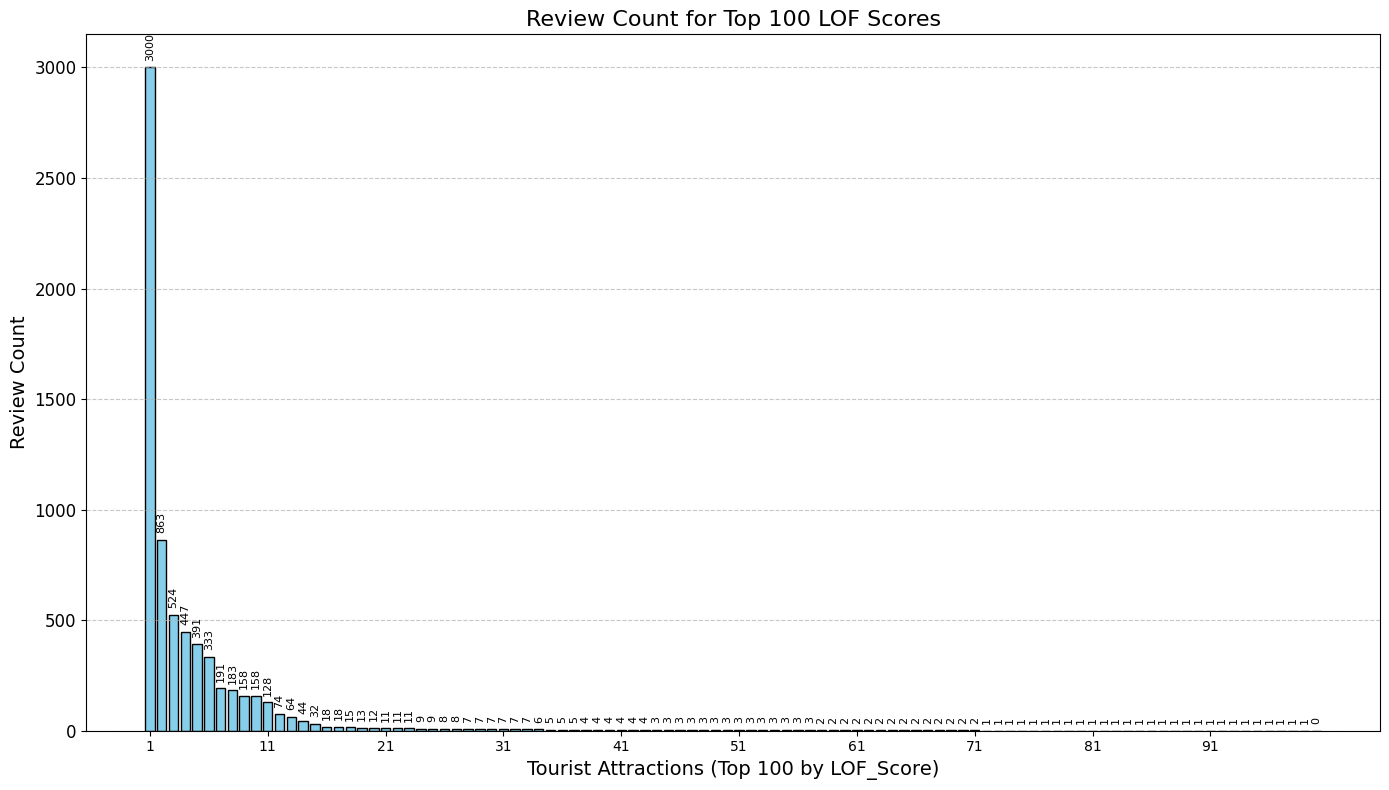

In [43]:
# ✅ LOF_Score 상위 100개 선택
top_100_lof = sorted_df.sort_values(by='LOF_Score', ascending=False).head(100)

# ✅ LOF_Score 상위 100개 선택 및 review_cnt 기준 정렬
top_100_lof_sorted = top_100_lof.sort_values(by='review_cnt', ascending=False).reset_index(drop=True)

# ✅ 시각화 (x축: 관광지 인덱스, y축: review_cnt)
plt.figure(figsize=(14, 8))
plt.bar(top_100_lof_sorted.index, top_100_lof_sorted['review_cnt'], color='skyblue', edgecolor='black')

plt.title("Review Count for Top 100 LOF Scores", fontsize=16)
plt.xlabel("Tourist Attractions (Top 100 by LOF_Score)", fontsize=14)
plt.ylabel("Review Count", fontsize=14)
plt.xticks(ticks=range(0, 100, 10), labels=[f'{i+1}' for i in range(0, 100, 10)], fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ 각 바 위에 개수 표시 (작은 글씨로)
for i, value in enumerate(top_100_lof_sorted['review_cnt']):
    plt.text(i, value + max(top_100_lof_sorted['review_cnt']) * 0.01, str(value), ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

In [44]:
# ✅ 1. review_cnt가 100개 넘는 데이터 제외
filtered_df = sorted_df[sorted_df['review_cnt'] <= 100]

# ✅ 2. LOF_Score 기준 상위 100개 필터링
top_100_lof_filtered = filtered_df.sort_values(by='LOF_Score', ascending=False).head(100)
top_100_lof_filtered.head()

,search_result,attraction_info,english_info,name,info,corpus,attraction_name,review_cnt,embedding,LOF_Score,is_outlier,LOF_Score_Category
996,충주 활옥동굴,"1922년 일제강점기에 개발된 국내 유일 활석 광산으로 기록상 57km, 비공식 8...",It is the only talc mine in Korea developed du...,Hwalok Cave,Hwalok Cave,it be the only talc mine in korea develop duri...,NaN,0,"[-0.08450809866189957, 0.05948633700609207, 0....",4.013665,-1,> 4
898,통일전 은행나무길,통일전 은행나무길은 경주시의 대표적인 가을 명소로 손꼽히는 곳이라고 할 수 있다. ...,The Tongiljeon Ginkgo Tree Road is considered ...,Gingko Tree Road,Gingko Tree Road,the tongiljeon ginkgo tree road be consider on...,Gingko Tree Road,4,"[0.0104845454916358, 0.09078939259052277, 0.02...",3.485174,-1,3 - 4
1002,대한성공회 강화성당,강화성당은 고요한 (Charies Jone Corfe) 초대주교가 1900년에 축성...,Ganghwa Cathedral was built in 1900 by the fir...,Ganghwa Anglican Cathedral,Ganghwa Anglican Cathedral,ganghwa cathedral be build in by the first bis...,Ganghwa Anglican Cathedral,3,"[0.047638799995183945, 0.046310052275657654, 0...",3.217466,-1,3 - 4
1142,대한성공회 서울주교좌성당,대한성공회 서울주교좌성당은 친교의 신앙으로 선교하는 제자공동체이다. 이 건물은 대한...,"The Anglican Church of Korea, Seoul Cathedral ...",Seoul Anglican Cathedral,Seoul Anglican Cathedral,the anglican church of korea seoul cathedral b...,Seoul Anglican Cathedral,7,"[0.040632497519254684, 0.036646075546741486, 0...",3.199203,-1,3 - 4
1381,나바위 성당(화산천주교회),나바위 성당은 조선 헌종 11년(1845년) 김대건 신부가 중국에서 사제서품을 받고...,Nabawi Cathedral was built in 1845 (the 11th y...,Choryang Catholic Church,Choryang Catholic Church,nabawi cathedral be build in the th year of ki...,Choryang Catholic Church,4,"[-0.005303469020873308, 0.0771574005484581, 0....",3.189261,-1,3 - 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


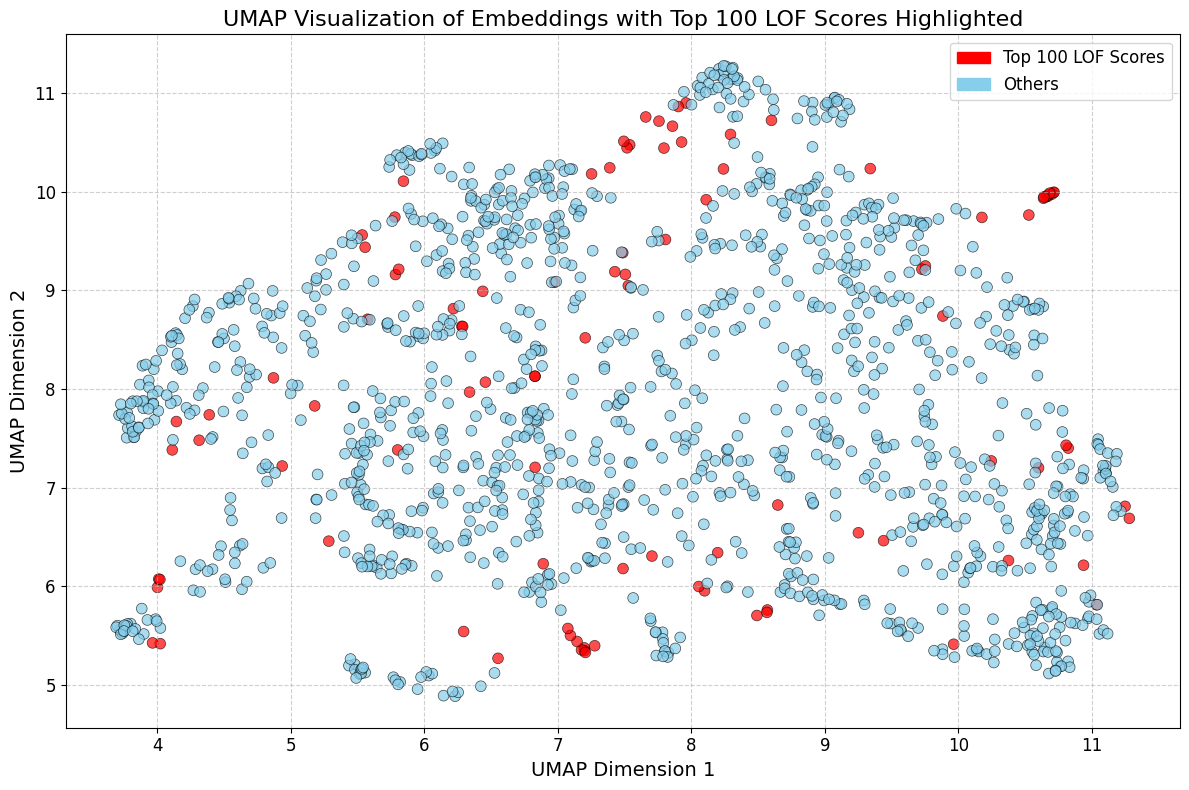

In [46]:
import numpy as np

# ✅ UMAP 객체 선언 및 임베딩 벡터 추출
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_vectors = np.vstack(sorted_df['embedding'].values)

# ✅ UMAP 적용하여 2차원으로 축소
umap_embeddings = umap_reducer.fit_transform(embedding_vectors)

# ✅ LOF_Score 기준 상위 100개 인덱스 추출
top_100_indices = sorted_df.sort_values(by='LOF_Score', ascending=False).head(100).index

# ✅ 색상 설정 (상위 100개와 나머지 구분)
colors = ['red' if idx in top_100_indices else 'skyblue' for idx in sorted_df.index]

# ✅ 시각화
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=colors, alpha=0.7, edgecolor='k', linewidth=0.5, s=60)

# ✅ 범례 추가
import matplotlib.patches as mpatches
top_patch = mpatches.Patch(color='red', label='Top 100 LOF Scores')
rest_patch = mpatches.Patch(color='skyblue', label='Others')
plt.legend(handles=[top_patch, rest_patch], fontsize=12)

plt.title("UMAP Visualization of Embeddings with Top 100 LOF Scores Highlighted", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.grid(linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()